conda(A) = 6.56e+04


Text(0.5, 1.0, '(L+D) preconditioner, n =200')

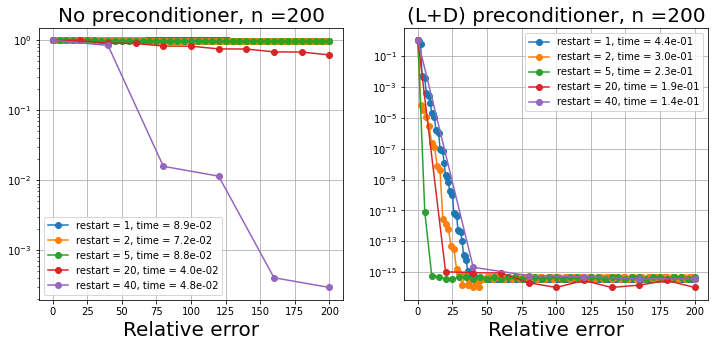

In [11]:
import numpy as np

import scipy
from scipy import sparse as scp_sps
from scipy.sparse import linalg as scp_sps_la
from matplotlib import pyplot as plt
from numba import jit, njit
import time

n = 200
np.random.seed(1)
A = np.random.rand(n, n)

A = A.T @ A
A = A / np.linalg.norm(A, 'fro')
A = A + 1e-4 * np.random.rand(n, n) + np.diag(np.arange(n) //2)

A_sparse = scp_sps.coo_matrix(A)

print('conda(A) = {0:5.2e}'.format(np.linalg.cond(A)))

# Implement preconditioner 
# Define function which computes P^-1 y
# @jit
def P_inv_x(y):
    # (L + D)^-1 y
    x = np.zeros_like(y)
    for i in range(A.shape[0]):
        x[i] = (y[i] - A[i, :i] @ x[:i]) / A[i, i]
    return x

# Define linear operator

P_inv = scp_sps_la.LinearOperator((n, n), P_inv_x)

b = np.random.rand(n)

x_ex = np.linalg.solve(A, b)

total_iter = n
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

for restart in [1, 2, 5, 20, 40]:
    errors = []
    
    def store_error(x):
        errors.append(np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex))
        return
    
    max_iter = total_iter // restart
    t1 = time.time()
    x0 = np.zeros(n)
    x_gmres, _ = scp_sps.linalg.gmres(
        A_sparse, b, x0, tol = 1e-20, maxiter = max_iter,
        restart = restart, callback = store_error, callback_type = 'x'
    )
    t2 = time.time()
    
    ax1.semilogy(
        np.arange(len(errors)) * restart, np.array(errors), '-o', 
        label = 'restart = {0:d}, time = {1:5.1e}'.format(restart, t2 - t1)
    )
    # Preconditioned system
    errors = []
    
    def store_error(x):
        errors.append(np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex))
        return
    
    x0 = np.zeros(n)
    t1 = time.time()
    x_gmres, _ = scp_sps.linalg.gmres(
        A_sparse, b, x0, tol = 1e-20, maxiter = max_iter, M = P_inv,
        restart = restart, callback = store_error, callback_type = 'x'
    )
    t2 = time.time()
    ax2.semilogy(
        np.arange(len(errors)) * restart, np.array(errors), '-o', 
        label = 'restart = {0:d}, time = {1:5.1e}'.format(restart, t2 - t1)
    )
    
for ax in (ax1, ax2):
    ax.grid(True)
    ax.set_xlabel('Iterations', fontsize = 20)
    ax.set_xlabel('Relative error', fontsize = 20)
    ax.legend()
    
ax1.set_title('No preconditioner, n ={0:d}'.format(n), fontsize = 20)
ax2.set_title('(L+D) preconditioner, n ={0:d}'.format(n), fontsize = 20)